In [ ]:
!pip install transformers

In [ ]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

In [ ]:
# !pip install protobuf==3.20.1

In [1]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [2]:
# Basic usage
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [3]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [4]:
# Output is a dictionary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [5]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [6]:
classifier("This show was interesting")

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [7]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [8]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278433918952942}]

In [9]:
# Multiple inputs passed in as a list
classifier([
  "This course is just what I needed.",
  "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [10]:
import torch

In [11]:
torch.cuda.is_available()

False

In [12]:
# Use the GPU
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [13]:
df_ = pd.read_csv('AirlineTweets.csv')

In [14]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [15]:
df = df_[['airline_sentiment', 'text']].copy()

<AxesSubplot:>

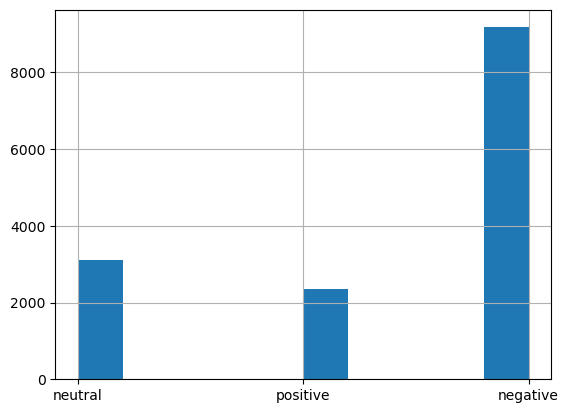

In [16]:
df['airline_sentiment'].hist()

In [17]:
df = df[df.airline_sentiment != 'neutral'].copy()

In [18]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [19]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [20]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [21]:
predictions

[{'label': 'POSITIVE', 'score': 0.6070873737335205},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854251742362976},
 {'label': 'POSITIVE', 'score': 0.9553210139274597},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [22]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] \
         for d in predictions]

In [23]:
probs

[0.6070873737335205,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574825763702393,
 0.9553210139274597,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.0004048943519592285,
 0.0006322264671325684,
 0.01542818546295166,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661721348762512,
 0.0003237724304199219,
 0.8415605425834656,
 0.0032317638397216797,
 0.9997846484184265,
 0.17614537477493286,
 0.9993895292282104,
 0.09156537055969238,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.9911696910858154,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [24]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

In [25]:
preds = np.array(preds)

In [26]:
print("acc:", np.mean(df['target'] == preds))

acc: 0.8898708950697514


In [27]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

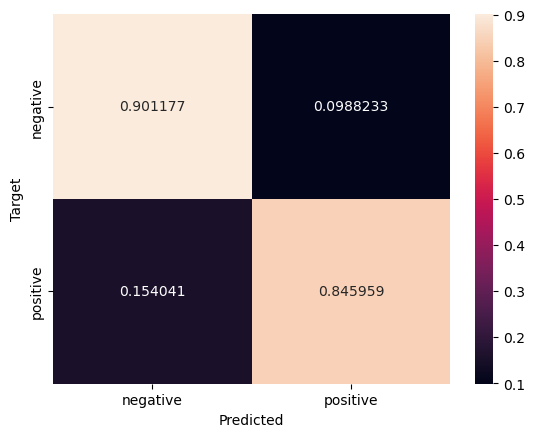

In [28]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [29]:
f1_score(df['target'], preds)

0.7587777566900741

In [30]:
f1_score(1 - df['target'], 1 - preds)

0.928647616908999

In [31]:
roc_auc_score(df['target'], probs)

0.948593515174145

In [32]:
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.948593515174145